In [40]:
import csv
import cv2
import math
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces

In [41]:
EIGENFACES_INPUT_FILE = 'input\\gray_eigenfaces\\eigenfaces.csv'

# Prepare Feature and Label arrays
X = []
Y = []

# Go through the input file
with open(EIGENFACES_INPUT_FILE, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip the header row
    header = next(csv_reader)

    # Read and append each row to X and Y
    for row in csv_reader:
        image_path = row[0]
        grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if grayscale_image is not None:
            X.append(grayscale_image)
            Y.append(int(row[1]))
        else:
            print(f"Error reading image: {image_path}")

# Convert X and Y lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(11, 56, 49)
(11,)


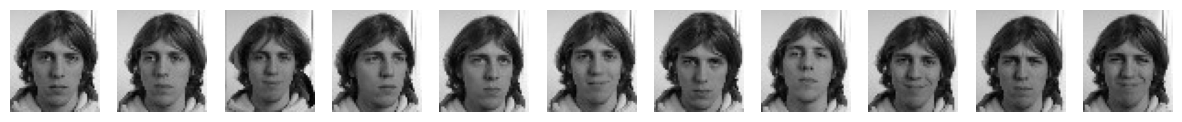

In [42]:
# Define the class to display (e.g., class 0)
class_to_display = 0

# Filter images with the specified class
images_to_display = X[Y == class_to_display]

# Display all images with the specified class
fig, axes = plt.subplots(1, len(images_to_display), figsize=(15, 15))

for i, image in enumerate(images_to_display):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.show()